---
---

# **Audio Classification**

We will follow the below scheme

![image.png](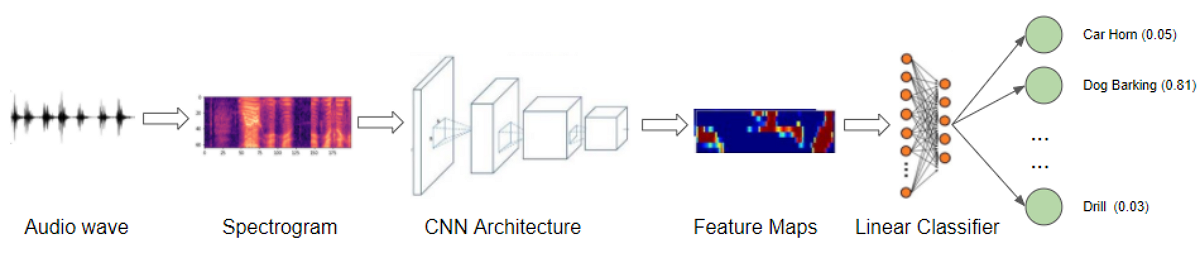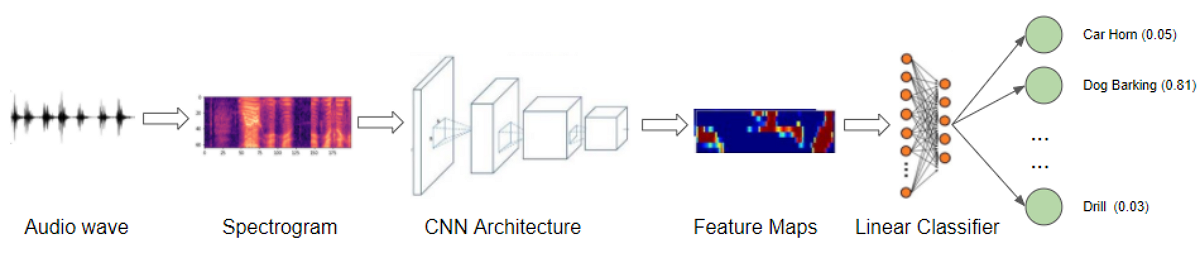)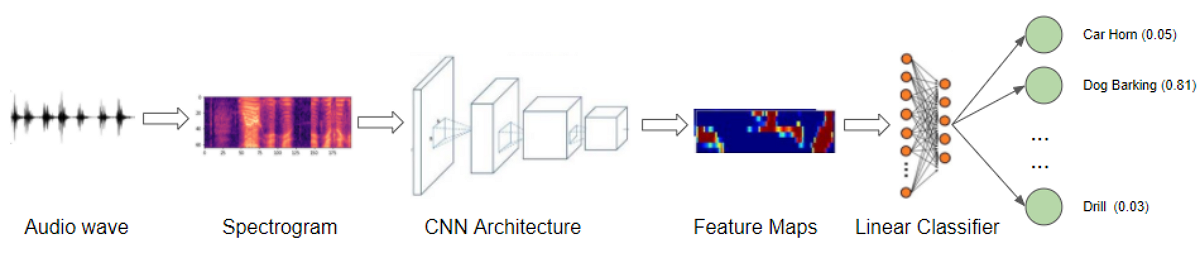

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

--2022-09-28 21:54:06--  https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156353364 (149M) [application/zip]
Saving to: ‘dataset_audio.zip’

dataset_audio.zip   100%[===================>] 149.11M  21.9MB/s    in 8.0s    

2022-09-28 21:54:15 (18.7 MB/s) - ‘dataset_audio.zip’ saved [156353364/156353364]

Archive:  dataset_audio.zip
   creating: dataset_audio/
  inflating: dataset_audio/I0014.wav  
  inflating: dataset_audio/I0044.wav  
  inflating: dataset_audio/I0094.wav  
  inflating: dataset_audio/I0114.wav  
  inflating: dataset_audio/I0164.wav  
  inflating: dataset_audio/I0194.wav  
  inflating: dataset_audio/I0264.wav  
  inflating: dataset_audio/I0304.wav  
  inflating: dataset_audio/I0354.wav  
  inflating: dataset_audio/I0374.wav  
  inflating: dataset_audio/I0384.wav  
  i

In [ ]:
!unzip dataset_audio.zip

unzip:  cannot find or open dataset_audio.zip, dataset_audio.zip.zip or dataset_audio.zip.ZIP.


---
---
# **Preprocessing**

In [ ]:
!pip install tensorflow_io
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.2 MB/s 
     |████████████████████████████████| 2.4 MB 49.9 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.layers.core import Dropout
from keras import regularizers
from tensorflow.keras.constraints import MaxNorm

from keras import initializers
from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D

In [ ]:
def delete_excess(data):
  return data[:length_audio]

def add_average(data):
  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  return result

def plot_spectrogram(spectrogram, ax, title, rate):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  ax.set_xlim([0, rate])
  ax.set_title(title)

def add_white_noise(signal, noise_factor):
  noise = np.random.normal(0, signal.std(),signal.size)
  return signal + noise  

def waveform_shift(data):
  return np.roll(data, 30000)



In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

rate, data = read(path)

length = data.shape[0] / rate   # 
length_audio = data.shape[0]    # 176400
nb_channels = data.shape[1]     # 2

n_samples = 0
for file_name in os.listdir(directory):
  n_samples += 1

dataset = np.zeros(shape=(n_samples, length_audio))

# creating the dataset and labels
labels = np.zeros(shape=(n_samples,))

for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

dataset = (dataset - np.mean(dataset)) / np.std(dataset)  # let's normalize

print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("| labels.shape : ", labels.shape)
print("----------------------------------")


In [ ]:
# let's separate indoor and outdoor data

args_indoor  = np.argwhere(labels==1)
args_outdoor = np.argwhere(labels==0)

dataset_indoor  = dataset[args_indoor].squeeze()
dataset_outdoor = dataset[args_outdoor].squeeze()

plt.bar([0,1], [dataset_outdoor.shape[0], dataset_indoor.shape[0]], width=0.2);

In [ ]:
# Showing audio waveform
timesteps = np.arange(dataset.shape[1])

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, dataset_indoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,2)
plt.plot(timesteps, dataset_outdoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

In [ ]:
# transformation to spectrogram

frame_length = 685
frame_step = int(frame_length/2)

spectrogram_indoor  = tf.abs(tf.signal.stft(signals=dataset_indoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))
spectrogram_outdoor = tf.abs(tf.signal.stft(signals=dataset_outdoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))

print("-----------------------------------------------")
print("|  dataset_indoor.shape:", dataset_indoor.shape)
print("|  spectrogram_indoor.shape:", spectrogram_indoor.shape)
print("-----------------------------------------------")
print("|  dataset_outdoor.shape:", dataset_outdoor.shape)
print("|  spectrogram_outdoor.shape:", spectrogram_outdoor.shape)
print("-----------------------------------------------")

-----------------------------------------------
|  dataset_indoor.shape: (56, 176400)
|  spectrogram_indoor.shape: (56, 514, 513)
-----------------------------------------------
|  dataset_outdoor.shape: (144, 176400)
|  spectrogram_outdoor.shape: (144, 514, 513)
-----------------------------------------------


In [ ]:
ipd.Audio(dataset_indoor[0,:], rate=rate)

In [ ]:
ipd.Audio(dataset_outdoor[0,:], rate=rate)

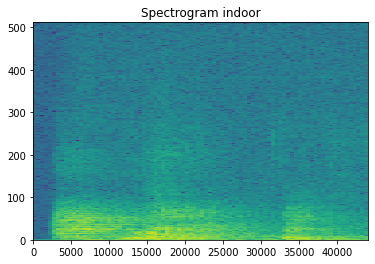

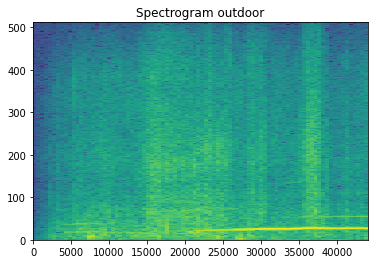

In [ ]:
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_indoor[0,:].numpy(), ax, 'Spectrogram indoor', rate)
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(spectrogram_outdoor[0,:].numpy(), ax, 'Spectrogram outdoor', rate)
plt.show()

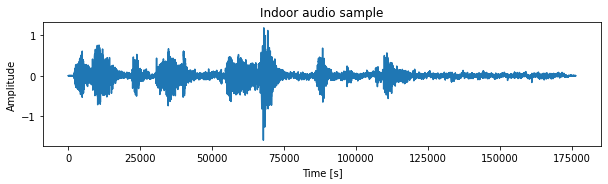

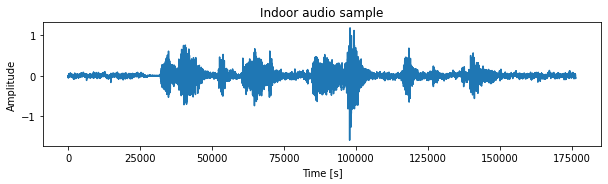

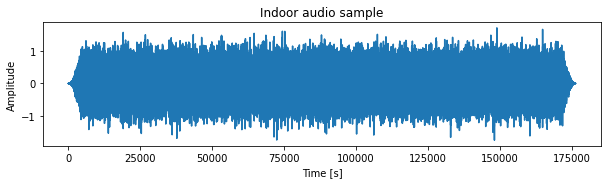

In [ ]:
#  Doing data augmentation to increase the quantity of data

expend_dataset_indoor = np.empty((112, 176400))

new_dataset_indoor = dataset_indoor
expended_data_index = 0

for temp_index in range(0, 56):

  for y in range(0, 2):
    
    expend_dataset_indoor[expended_data_index, :] = new_dataset_indoor[temp_index, :]
    new_dataset_indoor[temp_index, :] = waveform_shift(new_dataset_indoor[temp_index, :])  
    expended_data_index += 1


fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_indoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_indoor[1, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_indoor[2, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Indoor audio sample")
plt.show()


In [ ]:
expend_dataset_outdoor = np.empty((288, 176400))

new_dataset_outdoor = dataset_outdoor
expended_data_index = 0

for temp_index in range(0, 144):

  for y in range(0, 2):
    
    expend_dataset_outdoor[expended_data_index, :] = new_dataset_outdoor[temp_index, :]
    new_dataset_outdoor[temp_index, :] = waveform_shift(new_dataset_outdoor[temp_index, :])  
    expended_data_index += 1


fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_outdoor[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_outdoor[1, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(timesteps, expend_dataset_outdoor[2, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Outdoor audio sample")
plt.show()

In [ ]:
ipd.Audio(expend_dataset_indoor[0,:], rate=rate)

In [ ]:
ipd.Audio(expend_dataset_outdoor[1,:], rate=rate)

In [ ]:
# Adding all the data together to create a new dataset
new_dataset = np.empty((400, 176400))
new_index = 0
for x in range(288):
  new_dataset[new_index, :] = expend_dataset_outdoor[x, :]
  new_index += 1
for y in range(112):
  new_dataset[new_index, :] = expend_dataset_indoor[y, :]
  new_index += 1

In [ ]:
frame_length = 685
frame_step = int(frame_length/2)

spectrogram_indoor  = tf.abs(tf.signal.stft(signals=expend_dataset_indoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))
spectrogram_outdoor = tf.abs(tf.signal.stft(signals=expend_dataset_outdoor, frame_length=frame_length, frame_step=frame_step, fft_length=None))

print("-----------------------------------------------")
print("|  dataset_indoor.shape:", expend_dataset_indoor.shape)
print("|  spectrogram_indoor.shape:", spectrogram_indoor.shape)
print("-----------------------------------------------")
print("|  dataset_outdoor.shape:", expend_dataset_outdoor.shape)
print("|  spectrogram_outdoor.shape:", spectrogram_outdoor.shape)
print("-----------------------------------------------")

---
---
# **Model Building**

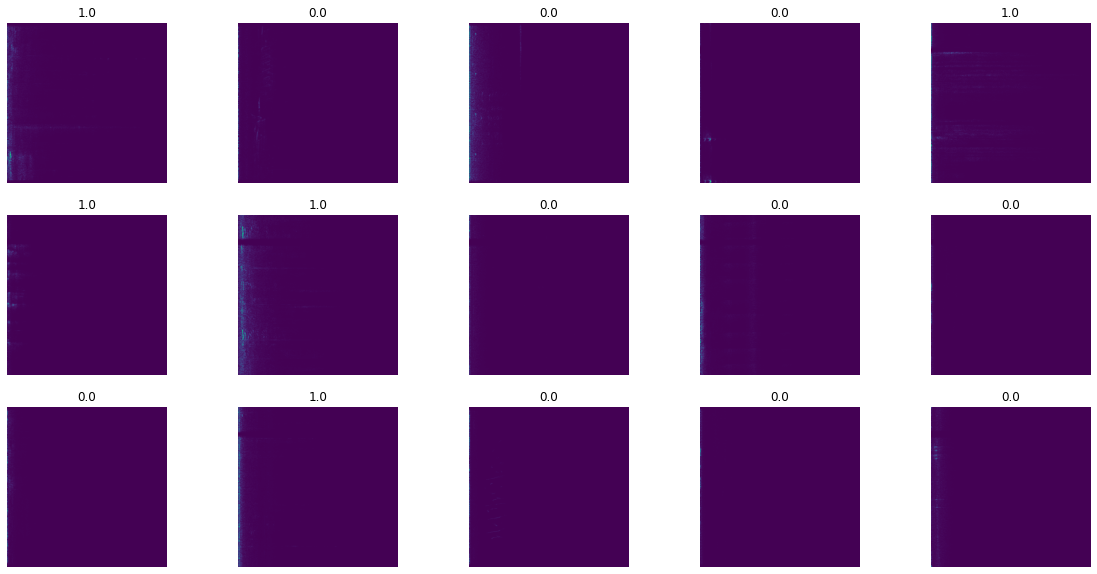

In [ ]:
# dataset creation

BATCH_SIZE  = 15
BUFFER_SIZE = 400

new_samples = 400

labels = np.zeros(shape=(new_samples,))
labels[:spectrogram_indoor.shape[0]] = 1

merge = np.concatenate((spectrogram_indoor, spectrogram_outdoor), axis=0)
merge = (merge - np.mean(merge)) / np.std(merge)

# shuffle

arg_shuffle = np.random.choice(new_samples, size=(new_samples), replace=False)

new_dataset = merge[arg_shuffle].reshape(merge.shape[0], merge.shape[1], merge.shape[2], 1)
labels  = labels[arg_shuffle]

plt.figure(figsize=(20, 10))
for index, images in enumerate(new_dataset[:15,:,:]):
  ax = plt.subplot(3, 5, index + 1)
  plt.imshow(images[:,:,0])
  plt.title(labels[index])
  plt.axis("off")

In [ ]:
def get_model():

  model = tf.keras.Sequential()


  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(new_dataset.shape[1], new_dataset.shape[2], new_dataset.shape[3]), kernel_constraint=MaxNorm(3)))
  model.add(MaxPooling2D(2, 2)) 

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.5))

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))

  model.add(Dropout(0.2)) 
  model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))

  optimizer = Adam(0.00002, beta_1=0.1)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 511, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 253, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 126, 128)    0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 126, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 124, 128)     1

---
---
# **Training**

In [ ]:
epochs=100


history = model.fit(new_dataset, labels, epochs=epochs, validation_split=0.3)

Epoch 1/100
9/9 [==============================] - 2s 196ms/step - loss: 2.3663 - binary_accuracy: 0.8429 - val_loss: 2.6717 - val_binary_accuracy: 0.7833
Epoch 2/100
9/9 [==============================] - 2s 179ms/step - loss: 2.3151 - binary_accuracy: 0.8607 - val_loss: 2.5178 - val_binary_accuracy: 0.7917
Epoch 3/100
9/9 [==============================] - 2s 179ms/step - loss: 2.2404 - binary_accuracy: 0.8464 - val_loss: 2.5283 - val_binary_accuracy: 0.7917
Epoch 4/100
9/9 [==============================] - 2s 179ms/step - loss: 2.2301 - binary_accuracy: 0.8607 - val_loss: 2.5211 - val_binary_accuracy: 0.7833
Epoch 5/100
9/9 [==============================] - 2s 180ms/step - loss: 2.2646 - binary_accuracy: 0.8536 - val_loss: 2.7609 - val_binary_accuracy: 0.7833
Epoch 6/100
9/9 [==============================] - 2s 180ms/step - loss: 2.2217 - binary_accuracy: 0.8429 - val_loss: 2.4950 - val_binary_accuracy: 0.7833
Epoch 7/100
9/9 [==============================] - 2s 178ms/step - los

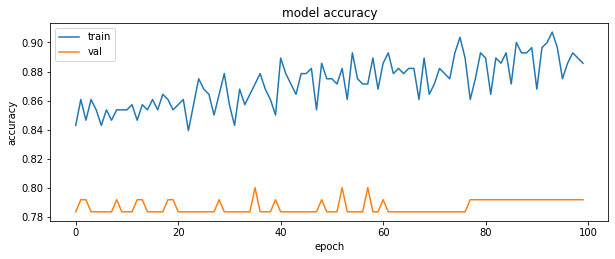

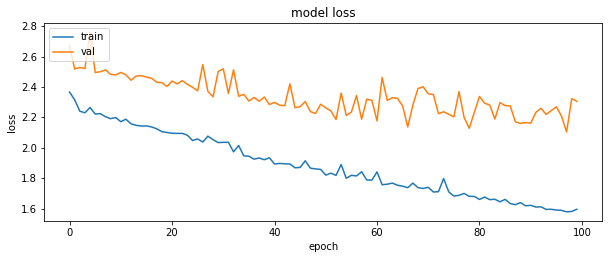

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
number_splits = 6
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(new_dataset, labels)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(new_dataset[fold_train], labels[fold_train], epochs=50, callbacks=[callback])

    scores = model.evaluate(new_dataset[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Training the fold number  1 

Epoch 1/50
11/11 [==============================] - 4s 211ms/step - loss: 8.2087 - binary_accuracy: 0.7267
Epoch 2/50
11/11 [==============================] - 2s 151ms/step - loss: 8.0579 - binary_accuracy: 0.7267
Epoch 3/50
11/11 [==============================] - 2s 150ms/step - loss: 7.8551 - binary_accuracy: 0.7267
Epoch 4/50
11/11 [==============================] - 2s 152ms/step - loss: 7.7320 - binary_accuracy: 0.7267
Epoch 5/50
11/11 [==============================] - 2s 151ms/step - loss: 6.8627 - binary_accuracy: 0.7297
Epoch 6/50
11/11 [==============================] - 2s 151ms/step - loss: 6.5771 - binary_accuracy: 0.7147
Epoch 7/50
11/11 [==============================] - 2s 151ms/step - loss: 6.1885 - binary_accuracy: 0.7087
Epoch 8/50
11/11 [==============================] - 2s 152ms/step - loss: 5.0724 - binary_accuracy: 0.7087
Epoch 9/50
11/11 [==============================] - 2s 150ms/step - loss: 4.0447 - bina

ResourceExhaustedError: ignored

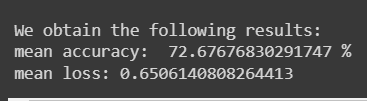